In [1]:
from IPython.display import HTML, clear_output, YouTubeVideo, IFrame
import json
import time
import pandas as pd
import os
from supabase import create_client
import datetime
from datetime import date
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [2]:
# Connect to database
url = os.environ.get("SUPABASE_URL")
key = os.environ.get("SUPABASE_KEY")
email = os.environ.get("EMAIL")
password = os.environ.get("PASSWORD")
client = create_client(url, key)
user = client.auth.sign_in(email=email, password=password)

In [3]:
def convert_time(time):
    '''function to convert total seconds to hours, minutes and seconds'''
    return str(datetime.timedelta(seconds=time))

clarity_list = ['easy', 'medium', 'hard', 'bad']

label = input('enter the label you want to review: ')

# create list of matching labels where clarity_level is none
clips = list(client.table('var_data').select('clarity_level', 'id', 'time_start', 'time_end', 'label').eq('clarity_level', 'none').eq('label', label).execute())[0][1]
clips

enter the label you want to review: person_pointing


[{'clarity_level': 'none',
  'id': 'R8vVsPCwKY410',
  'time_start': 453,
  'time_end': 459,
  'label': 'person_pointing'},
 {'clarity_level': 'none',
  'id': 'R8vVsPCwKY411',
  'time_start': 463,
  'time_end': 466,
  'label': 'person_pointing'},
 {'clarity_level': 'none',
  'id': 'R8vVsPCwKY412',
  'time_start': 532,
  'time_end': 537,
  'label': 'person_pointing'},
 {'clarity_level': 'none',
  'id': '4Hn2FjmhP4Q2',
  'time_start': 67,
  'time_end': 70,
  'label': 'person_pointing'},
 {'clarity_level': 'none',
  'id': '4Hn2FjmhP4Q3',
  'time_start': 83,
  'time_end': 85,
  'label': 'person_pointing'},
 {'clarity_level': 'none',
  'id': '4Hn2FjmhP4Q6',
  'time_start': 302,
  'time_end': 313,
  'label': 'person_pointing'},
 {'clarity_level': 'none',
  'id': '4Hn2FjmhP4Q7',
  'time_start': 422,
  'time_end': 431,
  'label': 'person_pointing'},
 {'clarity_level': 'none',
  'id': '4Hn2FjmhP4Q8',
  'time_start': 610,
  'time_end': 615,
  'label': 'person_pointing'},
 {'clarity_level': 'none'

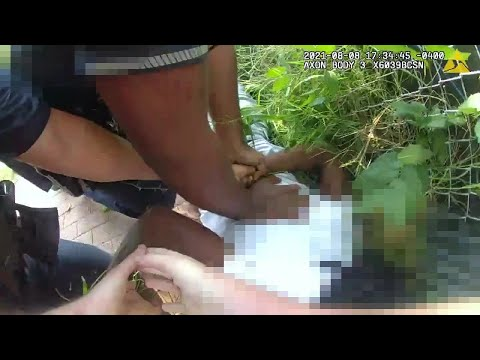

index:2/215 , id: R8vVsPCwKY412 , label: person_pointing , timestamp: 0:08:52 - 0:08:57 , clarity level: none
r = restart vid, t = change timestamp, cl = change clarity_level, n = next vid, p = previous vid, exit = exitexit


In [4]:
break_out = False
index = 0

while True:

    id = clips[index]['id']
    start = clips[index]['time_start']
    end = clips[index]['time_end']
    clarity = clips[index]['clarity_level']

    adjusting_annot = True
   

    if break_out == True:
        break

    if clarity != 'none':
        untagged = False
    else:
        untagged = True 


    while adjusting_annot == True:

        # play video
        clear_output(wait=True) 
        vid = YouTubeVideo(id[0:11], start=start, end=end, allow_autoplay=True, width=560, height=315)
        display(vid)

        # print data
        print(f'index:{index}/{len(clips)}', ', id:', id,', label:', label, 
                f', timestamp: {convert_time(start)} - {convert_time(end)}', ', clarity level:', clarity)

        data = input('r = restart vid, t = change timestamp, cl = change clarity_level, n = next vid, p = previous vid, exit = exit')


        # restart video
        if data == 'r':
            continue
        

        # change start and/or end time
        if data == 't':
            time_stamp = input('enter new timestamp (2:23, 2:34): ')
            
            try:
                # convert time to total seconds
                start = (int(time_stamp.split(',')[0].split(':')[0]) * 60) + int(time_stamp.split(',')[0].split(':')[1])
                end = (int(time_stamp.split(',')[1].split(':')[0]) * 60) + int(time_stamp.split(',')[1].split(':')[1])

                # insert new data into var_data
                client.table('var_data').update({'time_start': start, 'time_end': end}).eq('id', id).execute()

                # update data in list
                clips[index]['time_start'] = start
                clips[index]['time_end'] = end

            except:
                print('incorrect entry, try again')
                time.sleep(2)


        # change label
        if data == 'l':
            label = input('enter label: ')
            client.table('var_data').update({'label': label}).eq('id', id).execute()
            clips[index]['label'] = label

        # update clarity_level
        if data == 'cl':
            clarity = input('enter clarity_level (easy, medium, hard or bad): ')

            # insert new clarity_level to var_data
            if clarity in clarity_list:
                client.table('var_data').update({'clarity_level': clarity}).eq('id', id).execute()
                clips[index]['clarity_level'] = clarity
                untagged = False
            else:
                print('invalid input, try again')
                continue

        
        # go to next video
        if data == 'n':
            if untagged == True:
                print('no clarity_level tag on video')
                time.sleep(2)
                continue
            else:
                # add the date to the 'reviewed' column
                client.table('var_data').update({'reviewed': str(date.today())}).eq('id', id).execute()
                index += 1
                adjusting_annot = False    

        
        # go to previous video
        if data == 'p':
            index -= 1
            adjusting_annot = False
            break

        # exit program
        if data == 'exit':
            break_out = True
            adjusting_annot = False
            break
